In [0]:

# define widgets - NEED TO DEFINE IT ONCE
# dynamic variables (pass it from ADF)
# first time runtime parameter
# dbutils.widgets.dropdown("environment", "dev", ["dev","uat","prod"])
# dbutils.widgets.dropdown("new_training", "False", ["True","False"])
# dbutils.widgets.dropdown("system_name", "bimodelapi", ["bimodelapi"])
# dbutils.widgets.text("system_name", "","")
# dbutils.widgets.remove("pbiapi")
environment = dbutils.widgets.get("environment")
new_training = dbutils.widgets.get("new_training")
system_name = dbutils.widgets.get("system_name")
if environment in {"prod"}:
    aml_compute_cluster_name = "cc-bi-ml-prod01"
else:
    aml_compute_cluster_name = "cc-bi-ml-devqa01"

print(environment, system_name, new_training, aml_compute_cluster_name)



dev bimodelapi True cc-bi-ml-devqa01

dev bimodelapi True cc-bi-ml-devqa01

EnvironmentName,ParameterName,ParameterValue,SystemName
dev,ws_resource_group,rg-bi-automl-devqa01,bimodelapi
dev,workspace_name,mlw-bi-automl-devqa01,bimodelapi
dev,workspace_region,westus,bimodelapi


0 : ^GSPC,1 : ^FTSE,2 : ^N100,3 : ^N225,4 : 000001.SS,

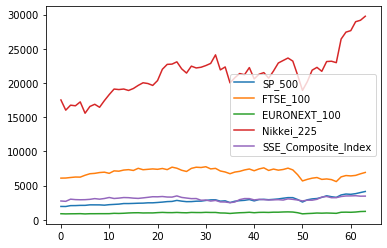

pipehist : (82186, 9)
talenthist : (4591, 6)
revhist : (424, 3)
opphist : (593, 7)
projhist : (701, 7)
pipetrend : (1245, 4)
projectactualshist : (1697, 4)

Out[11]: array(['2020-02-16T00:00:00.000000000', '2020-02-23T00:00:00.000000000',
 '2020-02-29T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
 '2020-03-08T00:00:00.000000000', '2020-03-15T00:00:00.000000000',
 '2020-03-22T00:00:00.000000000', '2020-06-07T00:00:00.000000000',
 '2020-06-14T00:00:00.000000000', '2020-06-21T00:00:00.000000000',
 '2020-06-28T00:00:00.000000000', '2020-06-30T00:00:00.000000000',
 '2020-07-05T00:00:00.000000000', '2020-07-12T00:00:00.000000000',
 '2020-07-19T00:00:00.000000000', '2020-07-26T00:00:00.000000000',
 '2020-07-31T00:00:00.000000000', '2020-08-02T00:00:00.000000000',
 '2020-08-09T00:00:00.000000000', '2020-08-16T00:00:00.000000000',
 '2020-08-23T00:00:00.000000000', '2020-08-30T00:00:00.000000000',
 '2020-08-31T00:00:00.000000000', '2020-09-06T00:00:00.000000000',
 '2020-09-13T00:00:00.000000000', '2020-09-20T00:00:00.000000000',
 '2020-09-27T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
 '2020-10-04T00:00:00.000000000', '2020-10-11T00:00:00.000000000',
 '2020-10-18T00:00:00.000000000', '2020-10-25T00:00:00.000000000',
 '2020-10-31T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
 '2020-11-08T00:00:00.000000000', '2020-11-15T00:00:00.000000000',
 '2020-11-22T00:00:00.000000000', '2020-11-29T00:00:00.000000000',
 '2020-11-30T00:00:00.000000000', '2020-12-06T00:00:00.000000000',
 '2020-12-13T00:00:00.000000000', '2020-12-20T00:00:00.000000000',
 '2020-12-27T00:00:00.000000000', '2020-12-31T00:00:00.000000000',
 '2021-01-03T00:00:00.000000000', '2021-01-10T00:00:00.000000000',
 '2021-01-17T00:00:00.000000000', '2021-01-24T00:00:00.000000000',
 '2021-01-31T00:00:00.000000000', '2021-02-07T00:00:00.000000000',
 '2021-02-14T00:00:00.000000000', '2021-02-21T00:00:00.000000000',
 '2021-02-28T00:00:00.000000000', '2021-03-07T00:00:00.000000000',
 '2021-03-14T00:00:00.000000000', '2021-03-21T00:00:00.000000000',
 '2021-03-28T00:00:00.000000000', '2021-03-31T00:00:00.000000000',
 '2021-04-03T00:00:00.000000000', '2021-04-04T00:00:00.000000000',
 '2021-04-05T00:00:00.000000000', '2021-04-06T00:00:00.000000000',
 '2021-04-07T00:00:00.000000000', '2021-04-08T00:00:00.000000000',
 '2021-04-09T00:00:00.000000000', '2019-11-24T00:00:00.000000000',
 '2019-11-30T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
 '2019-12-08T00:00:00.000000000', '2019-12-15T00:00:00.000000000',
 '2019-12-22T00:00:00.000000000', '2019-12-29T00:00:00.000000000',
 '2019-12-31T00:00:00.000000000', '2020-01-05T00:00:00.000000000',
 '2020-01-12T00:00:00.000000000', '2020-01-19T00:00:00.000000000',
 '2020-01-26T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
 '2020-02-02T00:00:00.000000000', '2020-02-09T00:00:00.000000000',
 '2020-03-29T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
 '2020-04-05T00:00:00.000000000', '2020-04-12T00:00:00.000000000',
 '2020-04-19T00:00:00.000000000', '2020-04-26T00:00:00.000000000',
 '2020-04-30T00:00:00.000000000', '2020-05-03T00:00:00.000000000',
 '2020-05-10T00:00:00.000000000', '2020-05-17T00:00:00.000000000',
 '2020-05-24T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
 '2019-07-28T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
 '2019-08-04T00:00:00.000000000', '2019-08-11T00:00:00.000000000',
 '2019-08-18T00:00:00.000000000', '2019-08-25T00:00:00.000000000',
 '2019-08-31T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
 '2019-09-08T00:00:00.000000000', '2019-09-15T00:00:00.000000000',
 '2019-09-22T00:00:00.000000000', '2019-09-29T00:00:00.000000000',
 '2019-09-30T00:00:00.000000000', '2019-10-06T00:00:00.000000000',
 '2019-10-13T00:00:00.000000000', '2019-10-20T00:00:00.000000000',
 '2019-10-27T00:00:00.000000000', '2019-10-31T00:00:00.000000000',
 '2019-11-03T00:00:00.000000000', '2019-11-10T00:00:00.000000000',
 '2019-11-17T00:00:00.000000000', '2018-07-20T00:00:00.000000000',
 '2018-07-22T00:00:00.000000000', '2018-07-29T00:00:00.000000000',
 '2018-07-31T00:00:00.000000000', '2018-08-05T00:00:00.000000000',
 '2018-08-12T00:00:00.000000000'

Out[12]: array(['2021-01-31T00:00:00.000000000', '2021-02-28T00:00:00.000000000',
 '2021-03-31T00:00:00.000000000', '2021-04-30T00:00:00.000000000',
 '2021-05-31T00:00:00.000000000', '2021-06-30T00:00:00.000000000',
 '2021-07-31T00:00:00.000000000', '2021-10-31T00:00:00.000000000',
 '2021-11-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000',
 '2022-01-31T00:00:00.000000000', '2021-08-31T00:00:00.000000000',
 '2021-09-30T00:00:00.000000000', '2022-02-28T00:00:00.000000000',
 '2022-03-31T00:00:00.000000000', '2017-01-31T00:00:00.000000000',
 '2017-02-28T00:00:00.000000000', '2017-03-31T00:00:00.000000000',
 '2017-04-30T00:00:00.000000000', '2017-05-31T00:00:00.000000000',
 '2017-06-30T00:00:00.000000000', '2017-07-31T00:00:00.000000000',
 '2017-08-31T00:00:00.000000000', '2017-09-30T00:00:00.000000000',
 '2017-10-31T00:00:00.000000000', '2017-11-30T00:00:00.000000000',
 '2017-12-31T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
 '2018-02-28T00:00:00.000000000', '2018-03-31T00:00:00.000000000',
 '2018-04-30T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
 '2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
 '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
 '2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
 '2018-12-31T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
 '2019-02-28T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
 '2019-04-30T00:00:00.000000000', '2019-05-31T00:00:00.000000000',
 '2019-06-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
 '2019-08-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
 '2019-10-31T00:00:00.000000000', '2019-11-30T00:00:00.000000000',
 '2019-12-31T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
 '2020-02-29T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
 '2020-04-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
 '2020-06-30T00:00:00.000000000', '2020-07-31T00:00:00.000000000',
 '2020-08-31T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
 '2020-10-31T00:00:00.000000000', '2020-11-30T00:00:00.000000000',
 '2020-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [0]:
%run ./data_load_rev_region_forecast

In [0]:
# Prepare Data & Set time column and series columns
print("Preparing data")
# set variales

target_column_name = "Revenue"
time_column_name = "End_of_Month"
time_series_id_column_names = ["Relative_Offset", "Sub_Region_Code"]
sort_cols_snp = ["End_of_Month", "Snapshot_Date", "Sub_Region_Code"]
sort_cols_eom = ["End_of_Month", "Sub_Region_Code"]

exclude_sub_region = ["Singapore", "NA"]

pd.set_option("display.float_format", lambda x: "%.2f" % x)

talenthist1 = talenthist.copy()  # .toPandas() to convert from spark df to pandas
pipehist1 = pipehist.copy()
opphist1 = opphist.copy()
projhist1 = projhist.copy()
revhist1 = revhist.copy()
pipetrend1 = pipetrend.copy()
projectactualshist1 = projectactualshist.copy()

# pipetrend1.drop(columns="Snapshot_Date_Short", axis=1, inplace=True)

pipehist1.rename(columns={"Snapshot_Date_Short": "Snapshot_Date"}, inplace=True)
pipetrend1.rename(columns={"Snapshot_Date_Short": "Snapshot_Date"}, inplace=True)
pipetrend1.rename(columns={"Snapshot_End_of_Month": "End_of_Month"}, inplace=True)
#talenthist1["Billable_Headcount"] = (
#    talenthist1["Headcount"] + talenthist1["Headcount_Contingent"]
#)
#talenthist1.drop(columns=["Headcount"], axis=1, inplace=True)

numeric_cols = [
    "Revenue",
    "Pipeline",
    "Pipeline_at_100_Percent",
    "Yield",
    "Pipeline_Trend",
    "Conversions",
    "Project_Period_Count",
    "Project_Count",
    "Project_Period_Price",
    "Project_Price",	
    "Opportunity_Period_Count",
    "Opportunity_Count",
    "Current_Opp._Period_Value",
    'Opportunity Value',
    "Win_Rate",
    "Headcount",
    "Utilization_Billable"
]

df_list = [
    pipehist1,
    talenthist1,
    revhist1,
    opphist1,
    projhist1,
    pipetrend1,
    projectactualshist1
]
for x in df_list:
    x.infer_objects()

    # convert date to to_datetime

    x = convert_date_cols(x)

    # coerce numeric_cols to numeric
    x = coerce_to_numeric(x)

    # replace null values to NA

    x["Sub_Region_Code"] = x["Sub_Region_Code"].replace(np.nan, "NA", regex=True)

    x = x.replace(np.nan, 0, regex=True)

    # make all dates to End of Month values to later merge
    if "End_of_Month" in x.columns:

        x["End_of_Month"] = x["End_of_Month"] + pd.offsets.MonthEnd(0)

    if "Snapshot_Date" in x.columns:

        # x['Snapshot_Date'] = x['Snapshot_Date'] + pd.offsets.MonthEnd(0)

        x.sort_values(by=["End_of_Month", "Snapshot_Date", "Sub_Region_Code"]).reset_index(drop=True)
    else:
        x.sort_values(by=sort_cols_eom).reset_index(drop=True)
    
    print(get_df_name(x), ":", x.shape)
    '''
    display(x.info())
    display(x.tail())
    '''


Preparing data
x : (82186, 9)
x : (4591, 6)
x : (424, 3)
x : (593, 7)
x : (701, 7)
x : (1245, 4)
x : (1697, 4)

In [0]:

# Cross join to get cross-join of all unquie values of End_of_Month + Relative_Offset + Snp_Seq_No + Sub_Region_Code with forward filling the last snapshot date for that relative_month
print("Preparing eom_region_snp_final")
# Set Parameters---------------------------------------------------------------------------------------------------------------------

past_period = 12
n_test_periods = 4
nan_value = 0
dt1 = pd.to_datetime('2018-07-31') #ignore revenues before pipeline data was not there

main_filter = "Relative_Offset >= -@past_period and \
                Relative_Offset < @n_test_periods and \
                Relative_Snapshot_Month_Offset <= 0 and \
                Snp_Seq_No == 6"

d = pd.date_range(start_date, today + pd.offsets.MonthEnd(n_test_periods), freq="m")
eom = pd.DataFrame(d, columns=["End_of_Month"])

# eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep='last').sort_values(by=['End_of_Month']).reset_index(drop=True)

sub_region = pd.DataFrame(
    pipehist1["Sub_Region_Code"].unique(), columns=["Sub_Region_Code"]
)
snp_date = pd.DataFrame(pipehist1["Snapshot_Date"].unique(), columns=["Snapshot_Date"])

eom1 = df_crossjoin(snp_date, eom)
eom1 = eom1.reset_index(drop=True)

eom2 = df_crossjoin(eom1, sub_region)
eom2 = eom2.reset_index(drop=True)
# eom1 = eom.merge(snp_date, how="cross")
# eom2 = eom1.merge(sub_region, how="cross")


eom_region_snp = eom2.replace(np.nan, "NA", regex=True).query(
    "Sub_Region_Code not in @exclude_sub_region"
)
eom_region_snp = eom_region_snp.reset_index(drop=True)
# eom_region_snp.drop(columns=['key'], axis=1, inplace = True)

# Add offset columns

eom_region_snp["Relative_Month_Offset"] = round(
    (eom_region_snp["End_of_Month"] - current_eom) / np.timedelta64(1, "M"), 0
).astype(int)
eom_region_snp["Relative_Snapshot_Month_Offset"] = round(
    (eom_region_snp["Snapshot_Date"] + pd.offsets.MonthEnd(0) - current_eom)
    / np.timedelta64(1, "M"),
    0,
).astype(int)
eom_region_snp["Relative_Offset"] = (
    eom_region_snp["Relative_Month_Offset"] -
    eom_region_snp["Relative_Snapshot_Month_Offset"]
)
eom_region_snp["Relative_Offset"] = eom_region_snp["Relative_Offset"].astype(int)
eom_region_snp["Snapshot_Day_of_Month"] = eom_region_snp["Snapshot_Date"].dt.day

eom_region_snp1 = eom_region_snp.copy()

# display(eom_region_snp.tail())

# Add a sequence number to each element in a group using python
seq = pd.DataFrame()
seq["Snp_Seq_No"] = [0, 1, 2, 3, 4, 5, 6]

eom_region_snp1 = eom_region_snp1.sort_values(by=["End_of_Month", "Snapshot_Date", "Sub_Region_Code"]).reset_index(drop=True)
#print("eom_region_snp1:")
#eom_region_snp1.info()
#display(eom_region_snp1.tail())

eom_region_snp2 = (
    eom_region_snp1[["End_of_Month", "Relative_Offset", "Snapshot_Date"]]
    .groupby(["End_of_Month", "Relative_Offset", "Snapshot_Date"])
    .last()
)

# eom_region_snp['Snp_Seq_No'] = normalize(eom_region_snp['Snapshot_Date'].dt.day,1,15) #Normalizing from one range to another

eom_region_snp2["Snp_Seq_No"] = eom_region_snp2.groupby(
    ["End_of_Month", "Relative_Offset"]
).cumcount()

cols1 = ["End_of_Month", "Relative_Offset"]
eom_offset_region = eom_region_snp1[cols1].drop_duplicates()
eom_offset_seq = df_crossjoin(eom_offset_region, seq)

#display(eom_offset_seq)
eom_region_snp2 = eom_region_snp2.reset_index(
    level=eom_region_snp2.index.names
).reset_index(drop=True)

#print("eom_region_snp2:")
#eom_region_snp2.info()
#display(eom_region_snp2)
#display(seq.info())

eom_region_snp3 = pd.merge(
    eom_offset_seq,
    eom_region_snp2,
    how = "left",
    on=["End_of_Month","Relative_Offset","Snp_Seq_No"]
)
eom_region_snp3 = eom_region_snp3.reset_index(drop=True)
#print("eom_region_snp3:")
#display(eom_region_snp3.info())

#display(eom_region_snp3.tail())

eom_region_snp3 = eom_region_snp3.ffill(axis=0)

eom_region_snp_final = pd.merge(
    eom_region_snp1,
    eom_region_snp3,
    how="right",
    on=["End_of_Month", "Relative_Offset", "Snapshot_Date"],
).fillna(nan_value)
eom_region_snp_final = eom_region_snp_final.reset_index(drop=True)

eom_region_snp_final = eom_region_snp_final.replace(np.nan, 0, regex=True)
#print("eom_region_snp_final:")
#display(eom_region_snp_final.info())

int_cols = [
    "Relative_Snapshot_Month_Offset",
    "Relative_Month_Offset",
    "Relative_Offset",
    "Snp_Seq_No",
    "Snapshot_Day_of_Month"
]

eom_region_snp_final = coerce_to_int(eom_region_snp_final)


# FILTER for relevant history and forecast period rows
eom_region_snp_final = eom_region_snp_final.query(main_filter).sort_values(by=sort_cols_snp).reset_index(drop=True)

eom_region_snp_final.to_csv(output_data_path + "eom_region_snp.csv", index=False)

print("eom_region_snp_final:")
#eom_region_snp_final['End_of_Month'].unique()
eom_region_snp_final.info()
eom_region_snp_final.tail()


Preparing eom_region_snp_final
eom_region_snp_final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 8 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date 4352 non-null datetime64[ns]
 1 End_of_Month 4352 non-null datetime64[ns]
 2 Sub_Region_Code 4352 non-null object 
 3 Relative_Month_Offset 4352 non-null int64 
 4 Relative_Snapshot_Month_Offset 4352 non-null int64 
 5 Relative_Offset 4352 non-null int64 
 6 Snapshot_Day_of_Month 4352 non-null int64 
 7 Snp_Seq_No 4352 non-null int64 
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 272.1+ KB
Out[14]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No
4347,2021-04-07,2021-07-31,Europe,3,0,3,7,6
4348,2021-04-07,2021-07-31,Global,3,0,3,7,6
4349,2021-04-07,2021-07-31,Japan,3,0,3,7,6
4350,2021-04-07,2021-07-31,North America,3,0,3,7,6
4351,2021-04-07,2021-07-31,Play Lab,3,0,3,7,6


In [0]:
pd.DataFrame(eom_region_snp_final.describe(include='all').transpose().head())
#'''
eom_region_snp_pvt = eom_region_snp_final.pivot_table(
    index=[time_column_name, "Relative_Offset"],
    columns=["Snp_Seq_No", "Sub_Region_Code"],
    values=["Snapshot_Date"],
    aggfunc={"Snapshot_Date": "count"},
    margins=False,
)
# eom_region_snp_pvt = eom_region_snp_pvt.reset_index(level=eom_region_snp_pvt.index.names).reset_index(drop=True)
eom_region_snp_pvt
#'''

Out[15]:

Snapshot_Date 
 
 
 
 Snp_Seq_No 
 6 
 
 
 
 Sub_Region_Code 
 Academy 
 Centers of Excellence 
 China 
 Europe 
 Global 
 Japan 
 North America 
 Play Lab 
 
 
 End_of_Month 
 Relative_Offset 
 
 
 
 
 
 
 
 
 
 
 
 
 2017-07-31 
 -12 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 2017-08-31 
 -12 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 -11 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 2017-09-30 
 -12 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 -11 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 2021-05-31 
 2 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 3 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 2021-06-30 
 2 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 3 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 2021-07-31 
 3 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 
 544 rows × 8 columns

In [0]:

# Pivot Talent from long to wide to match month end grain
print("Preparing talent wide")
nan_value = 0
#display(talenthist1.tail())

talenthist_wide1 = talenthist1.pivot_table(
    index=["End_of_Month", "Sub_Region_Code"],
    columns=["Billable", "Journey_Level"],
    values=["Headcount"],
    aggfunc={"Headcount": np.sum},
    margins=False,
).fillna(nan_value)


talenthist_wide1.columns = [
    "_".join(tuple(map(str, t))) for t in talenthist_wide1.columns.values
]

talenthist_wide1.reset_index(inplace=True)
talent_cols1 = talenthist_wide1.columns
remove_list1 = ["End_of_Month", "Sub_Region_Code", "Headcount"]
talent_cols1 = difflist(talent_cols1, remove_list1)
#print(talent_cols1)

# Sum contingent at month, billable, sub-region level
talenthist_wide2 = talenthist1.pivot_table(
    index=["End_of_Month", "Sub_Region_Code"],
    columns=["Billable"],
    values=["Headcount_Contingent"],
    aggfunc={"Headcount_Contingent": np.sum},
    margins=False,
).fillna(nan_value)

talenthist_wide2.columns = [
    "_".join(tuple(map(str, t))) for t in talenthist_wide2.columns.values
]

talenthist_wide2.reset_index(inplace=True)
talent_cols2 = talenthist_wide2.columns
remove_list2 = ["End_of_Month", "Sub_Region_Code", "Headcount_Contingent"]
talent_cols2 = difflist(talent_cols2, remove_list2)
#print(talent_cols2)

# talenthist_wide.tail()
# pipetrend_wide['Pipeline'] = pd.to_numeric(pipetrend_wide['Pipeline'], errors='coerce').astype(int)

talent_cols = talent_cols1 + talent_cols2
numeric_cols_talent = numeric_cols
numeric_cols_talent = numeric_cols_talent + talent_cols
numeric_cols = numeric_cols_talent
print(numeric_cols)

talenthist_wide1 = coerce_to_numeric(talenthist_wide1)
talenthist_wide1 = convert_date_cols(talenthist_wide1)
talenthist_wide1 = talenthist_wide1.sort_values(by=sort_cols_eom).reset_index(drop=True)

talenthist_wide2 = coerce_to_numeric(talenthist_wide2)
talenthist_wide2 = convert_date_cols(talenthist_wide2)
talenthist_wide2 = talenthist_wide2.sort_values(by=sort_cols_eom).reset_index(drop=True)

# print(' pipetrend_wide: ')

#display(talenthist_wide1.info())
#display(talenthist_wide2.info())
'''
# pipetrend_wide.query('Fin_Entity_ID==@entity_debug')
#print("talenthist_wide:", talenthist_wide.shape)
#talenthist_wide.tail()  # .query('Relative_Snapshot_Month_Offset == 0')
'''

Preparing talent wide
['Revenue', 'Pipeline', 'Pipeline_at_100_Percent', 'Yield', 'Pipeline_Trend', 'Conversions', 'Project_Period_Count', 'Project_Count', 'Project_Period_Price', 'Project_Price', 'Opportunity_Period_Count', 'Opportunity_Count', 'Current_Opp._Period_Value', 'Opportunity Value', 'Win_Rate', 'Headcount', 'Utilization_Billable', 'Headcount_Non-Billable_Team', 'Headcount_Non-Billable_Director', 'Headcount_Non-Billable_Unknown', 'Headcount_Billable_Individual', 'Headcount_Billable_Unknown', 'Headcount_Unknown_Unknown', 'Headcount_Billable_Enterprise', 'Headcount_Billable_Team', 'Headcount_Non-Billable_Enterprise', 'Headcount_Billable_Temp', 'Headcount_Unknown_Team', 'Headcount_Unknown_Enterprise', 'Headcount_Billable_Director', 'Headcount_Unknown_Individual', 'Headcount_Non-Billable_Individual', 'Headcount_Unknown_Director', 'Headcount_Contingent_Non-Billable', 'Headcount_Contingent_Unknown', 'Headcount_Contingent_Billable']
Out[16]: '\n# pipetrend_wide.query(\'Fin_Entity_ID==@entity_debug\')\n#print("talenthist_wide:", talenthist_wide.shape)\n#talenthist_wide.tail() # .query(\'Relative_Snapshot_Month_Offset == 0\')\n'

In [0]:

# Pivot ProjectActuals from long to wide to match month end grain
print("Preparing ProjectActuals wide")
nan_value = 0

projectactualshist_wide = projectactualshist1.pivot_table(
    index=["End_of_Month", "Sub_Region_Code"],
    columns="Journey_Level",
    values=["Utilization_Billable"],
    aggfunc={"Utilization_Billable": np.sum},
    margins=False,
).fillna(nan_value)


projectactualshist_wide.columns = [
    "_".join(tuple(map(str, t))) for t in projectactualshist_wide.columns.values
]

projectactualshist_wide.reset_index(inplace=True)
projectactuals_cols = projectactualshist_wide.columns
remove_list = ["End_of_Month", "Sub_Region_Code", "Utilization_Billable"]
projectactuals_cols = difflist(projectactuals_cols, remove_list)
#print(projectactuals_cols)
    
numeric_cols_projectactuals = numeric_cols
numeric_cols_projectactuals = numeric_cols_projectactuals + projectactuals_cols
print(numeric_cols_projectactuals)

numeric_cols = numeric_cols_projectactuals
projectactualshist_wide = coerce_to_numeric(projectactualshist_wide)
projectactualshist_wide = convert_date_cols(projectactualshist_wide)
projectactualshist_wide = projectactualshist_wide.sort_values(by=sort_cols_eom).reset_index(drop=True)

# print(' projectactualshist_wide: ')

display(projectactualshist_wide.info())
#display(projectactualshist_wide.tail())
'''
# projectactualshist_wide.query('Fin_Entity_ID==@entity_debug')
print("projectactualshist_wide:", projectactualshist_wide.shape)
'''


Preparing ProjectActuals wide
['Revenue', 'Pipeline', 'Pipeline_at_100_Percent', 'Yield', 'Pipeline_Trend', 'Conversions', 'Project_Period_Count', 'Project_Count', 'Project_Period_Price', 'Project_Price', 'Opportunity_Period_Count', 'Opportunity_Count', 'Current_Opp._Period_Value', 'Opportunity Value', 'Win_Rate', 'Headcount', 'Utilization_Billable', 'Headcount_Non-Billable_Team', 'Headcount_Non-Billable_Director', 'Headcount_Non-Billable_Unknown', 'Headcount_Billable_Individual', 'Headcount_Billable_Unknown', 'Headcount_Unknown_Unknown', 'Headcount_Billable_Enterprise', 'Headcount_Billable_Team', 'Headcount_Non-Billable_Enterprise', 'Headcount_Billable_Temp', 'Headcount_Unknown_Team', 'Headcount_Unknown_Enterprise', 'Headcount_Billable_Director', 'Headcount_Unknown_Individual', 'Headcount_Non-Billable_Individual', 'Headcount_Unknown_Director', 'Headcount_Contingent_Non-Billable', 'Headcount_Contingent_Unknown', 'Headcount_Contingent_Billable', 'Utilization_Billable_Enterprise', 'Utilization_Billable_Unknown', 'Utilization_Billable_Team', 'Utilization_Billable_Individual', 'Utilization_Billable_Director', 'Utilization_Billable_Temp']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 365 non-null datetime64[ns]
 1 Sub_Region_Code 365 non-null object 
 2 Utilization_Billable_Director 365 non-null float64 
 3 Utilization_Billable_Enterprise 365 non-null float64 
 4 Utilization_Billable_Individual 365 non-null float64 
 5 Utilization_Billable_Team 365 non-null float64 
 6 Utilization_Billable_Temp 365 non-null float64 
 7 Utilization_Billable_Unknown 365 non-null float64 
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 22.9+ KB
Out[17]: '\n# projectactualshist_wide.query(\'Fin_Entity_ID==@entity_debug\')\nprint("projectactualshist_wide:", projectactualshist_wide.shape)\n'

In [0]:

# Pivot Pipeline_Trend from long to wide to match month end grain
'''
print("Preparing Pipeline_Trend Wide")

nan_value = 0
pipetrend_wide = pipetrend1.pivot_table(
    index=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"],
    columns="Pipeline_Type",
    values=["Pipeline_Trend"],  # , 'Pipeline_3M_Rolling_Avg'
    aggfunc={"Pipeline_Trend": np.sum},
    margins=False,
).fillna(nan_value)


pipetrend_wide.columns = [
    "_".join(tuple(map(str, t))) for t in pipetrend_wide.columns.values
]

pipe_cols = [
    "Active_Unrecognized_Trend",
    "Opportunity_Trend",
    "Opportunity_ML_Trend",  # ,    "Recognized",
]

pipetrend_wide.columns = pipe_cols

pipetrend_wide = pipetrend_wide.reset_index(
    level=pipetrend_wide.index.names
).reset_index(drop=True)

numeric_cols_pipetrend = numeric_cols
numeric_cols_pipetrend = numeric_cols_pipetrend + pipe_cols
if "Pipeline_Trend" in numeric_cols_pipetrend:
    numeric_cols_pipetrend.remove("Pipeline_Trend")
print(numeric_cols_pipetrend)

numeric_cols = numeric_cols_pipetrend
pipetrend_wide = convert_date_cols(pipetrend_wide)
pipetrend_wide = coerce_to_numeric(pipetrend_wide)
pipetrend_wide = coerce_to_int(pipetrend_wide)

pipetrend_wide = pipetrend_wide.sort_values(by=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"]).reset_index(drop=True)

# print(' pipetrend_wide: ')

display(pipetrend_wide.info())

# pipetrend_wide.query('Fin_Entity_ID==@entity_debug')
print("pipetrend_wide:", pipetrend_wide.shape)
#pipetrend_wide.tail()  # .query('Relative_Snapshot_Month_Offset == 0')

'''

Out[18]: '\nprint("Preparing Pipeline_Trend Wide")\n\nnan_value = 0\npipetrend_wide = pipetrend1.pivot_table(\n index=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"],\n columns="Pipeline_Type",\n values=["Pipeline_Trend"], # , \'Pipeline_3M_Rolling_Avg\'\n aggfunc={"Pipeline_Trend": np.sum},\n margins=False,\n).fillna(nan_value)\n\n\npipetrend_wide.columns = [\n "_".join(tuple(map(str, t))) for t in pipetrend_wide.columns.values\n]\n\npipe_cols = [\n "Active_Unrecognized_Trend",\n "Opportunity_Trend",\n "Opportunity_ML_Trend", # , "Recognized",\n]\n\npipetrend_wide.columns = pipe_cols\n\npipetrend_wide = pipetrend_wide.reset_index(\n level=pipetrend_wide.index.names\n).reset_index(drop=True)\n\nnumeric_cols_pipetrend = numeric_cols\nnumeric_cols_pipetrend = numeric_cols_pipetrend + pipe_cols\nif "Pipeline_Trend" in numeric_cols_pipetrend:\n numeric_cols_pipetrend.remove("Pipeline_Trend")\nprint(numeric_cols_pipetrend)\n\nnumeric_cols = numeric_cols_pipetrend\npipetrend_wide = convert_date_cols(pipetrend_wide)\npipetrend_wide = coerce_to_numeric(pipetrend_wide)\npipetrend_wide = coerce_to_int(pipetrend_wide)\n\npipetrend_wide = pipetrend_wide.sort_values(by=["Snapshot_Date", "End_of_Month", "Sub_Region_Code"]).reset_index(drop=True)\n\n# print(\' pipetrend_wide: \')\n\ndisplay(pipetrend_wide.info())\n\n# pipetrend_wide.query(\'Fin_Entity_ID==@entity_debug\')\nprint("pipetrend_wide:", pipetrend_wide.shape)\n#pipetrend_wide.tail() # .query(\'Relative_Snapshot_Month_Offset == 0\')\n\n'

In [0]:

# Merge eom_studio with Revenue, Talent, Opportunity, Project
print("Preparing merge_df")
from functools import reduce

nan_value = 0
merge_dfs = [eom_region_snp_final, revhist1, projhist1, opphist1, projectactualshist_wide, talenthist_wide1, talenthist_wide2]

merge_df = reduce(
    lambda left, right: pd.merge(
        left, right, how="left", on=["End_of_Month", "Sub_Region_Code"]
    ),
    merge_dfs,
).fillna(nan_value)


merge_df = convert_date_cols(merge_df)
merge_df = coerce_to_numeric(merge_df)
merge_df = coerce_to_int(merge_df)

merge_df = merge_df.replace(np.nan, 0, regex=True)
merge_df.sort_values(by=sort_cols_snp).reset_index(drop=True)

# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)

#print(" merge_df: ", merge_df.shape)

# merge_df.to_csv(output_data_path   'merge_df.csv', index=False)
# show_stats(merge_df)
merge_df.info()
#print(merge_df.shape)
#merge_df.tail()  # .query('Fin_Entity_ID==@entity_debug')')



Preparing merge_df
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4352 entries, 0 to 4351
Data columns (total 44 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date 4352 non-null datetime64[ns]
 1 End_of_Month 4352 non-null datetime64[ns]
 2 Sub_Region_Code 4352 non-null object 
 3 Relative_Month_Offset 4352 non-null int64 
 4 Relative_Snapshot_Month_Offset 4352 non-null int64 
 5 Relative_Offset 4352 non-null int64 
 6 Snapshot_Day_of_Month 4352 non-null int64 
 7 Snp_Seq_No 4352 non-null int64 
 8 Revenue 4352 non-null float64 
 9 Project_Period_Count 4352 non-null float64 
 10 Project_Count 4352 non-null float64 
 11 Project_Period_Price 4352 non-null float64 
 12 Project_Price 4352 non-null float64 
 13 Conversions 4352 non-null float64 
 14 Opportunity_Period_Count 4352 non-null float64 
 15 Opportunity_Count 4352 non-null float64 
 16 Current_Opp._Period_Value 4352 non-null float64 
 17 Opportunity_Value 4352 non-null float64 
 18 Win_Rate 4352 non-null float64 
 19 Utilization_Billable_Director 4352 non-null float64 
 20 Utilization_Billable_Enterprise 4352 non-null float64 
 21 Utilization_Billable_Individual 4352 non-null float64 
 22 Utilization_Billable_Team 4352 non-null float64 
 23 Utilization_Billable_Temp 4352 non-null float64 
 24 Utilization_Billable_Unknown 4352 non-null float64 
 25 Headcount_Billable_Director 4352 non-null float64 
 26 Headcount_Billable_Enterprise 4352 non-null float64 
 27 Headcount_Billable_Individual 4352 non-null float64 
 28 Headcount_Billable_Team 4352 non-null float64 
 29 Headcount_Billable_Temp 4352 non-null float64 
 30 Headcount_Billable_Unknown 4352 non-null float64 
 31 Headcount_Non-Billable_Director 4352 non-null float64 
 32 Headcount_Non-Billable_Enterprise 4352 non-null float64 
 33 Headcount_Non-Billable_Individual 4352 non-null float64 
 34 Headcount_Non-Billable_Team 4352 non-null float64 
 35 Headcount_Non-Billable_Unknown 4352 non-null float64 
 36 Headcount_Unknown_Director 4352 non-null float64 
 37 Headcount_Unknown_Enterprise 4352 non-null float64 
 38 Headcount_Unknown_Individual 4352 non-null float64 
 39 Headcount_Unknown_Team 4352 non-null float64 
 40 Headcount_Unknown_Unknown 4352 non-null float64 
 41 Headcount_Contingent_Billable 4352 non-null float64 
 42 Headcount_Contingent_Non-Billable 4352 non-null float64 
 43 Headcount_Contingent_Unknown 4352 non-null float64 
dtypes: datetime64[ns](2), float64(36), int64(5), object(1)
memory usage: 1.5+ MB

In [0]:

# Merge with eom_region_snp1 with stock_final_pivot
print("Preparing merge_df1")
# eom1 = eom  # pd.DataFrame(d, columns=['End_of_Month'])
# stock_final_df = pd.merge(
#    eom_region_snp1, stock_final_pivot, how="left", on=["End_of_Month","Relative_Month_Offset","Relative_Snapshot_Month_Offset","Relative_Offset"]
# ).fillna(nan_value)

# sp500_df = sp500_df.ffill(axis = 0)

# stock_final_df = stock_final_df.sort_values(by=sort_cols_eom).reset_index(drop=True)
# display(sp500_df.tail(10))
merge_df1 = pd.merge(merge_df, stock_final_pivot, how="left", on="End_of_Month").fillna(
    nan_value
)
#print(symbols_name)

numeric_cols_stock = numeric_cols
numeric_cols_stock = numeric_cols_stock + symbols_name
#if "Pipeline_Trend" in numeric_cols_stock:
#    numeric_cols_stock.remove("Pipeline_Trend")
print(numeric_cols_stock)

numeric_cols = numeric_cols_stock
merge_df1 = convert_date_cols(merge_df1)
merge_df1 = coerce_to_numeric(merge_df1)
merge_df1 = coerce_to_int(merge_df1)

merge_df1 = merge_df1.sort_values(by=sort_cols_snp).reset_index(drop=True)
# merge_df1.to_csv(output_data_path   'merge_df1.csv', index=False)
# merge_sdf1 = spark.createDataFrame(merge_df1);
# merge_sdf1.write.format("parquet").mode("overwrite").parquet(output_data_path   'merge_df1.parquet')

# show_stats(merge_df1.tail(10))
# merge_df1.info()
#print(merge_df1.shape)
merge_df1.info()
#merge_df1.tail()



Preparing merge_df1
['Revenue', 'Pipeline', 'Pipeline_at_100_Percent', 'Yield', 'Pipeline_Trend', 'Conversions', 'Project_Period_Count', 'Project_Count', 'Project_Period_Price', 'Project_Price', 'Opportunity_Period_Count', 'Opportunity_Count', 'Current_Opp._Period_Value', 'Opportunity Value', 'Win_Rate', 'Headcount', 'Utilization_Billable', 'Headcount_Non-Billable_Team', 'Headcount_Non-Billable_Director', 'Headcount_Non-Billable_Unknown', 'Headcount_Billable_Individual', 'Headcount_Billable_Unknown', 'Headcount_Unknown_Unknown', 'Headcount_Billable_Enterprise', 'Headcount_Billable_Team', 'Headcount_Non-Billable_Enterprise', 'Headcount_Billable_Temp', 'Headcount_Unknown_Team', 'Headcount_Unknown_Enterprise', 'Headcount_Billable_Director', 'Headcount_Unknown_Individual', 'Headcount_Non-Billable_Individual', 'Headcount_Unknown_Director', 'Headcount_Contingent_Non-Billable', 'Headcount_Contingent_Unknown', 'Headcount_Contingent_Billable', 'Utilization_Billable_Enterprise', 'Utilization_Billable_Unknown', 'Utilization_Billable_Team', 'Utilization_Billable_Individual', 'Utilization_Billable_Director', 'Utilization_Billable_Temp', 'SP_500', 'FTSE_100', 'EURONEXT_100', 'Nikkei_225', 'SSE_Composite_Index']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 49 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date 4352 non-null datetime64[ns]
 1 End_of_Month 4352 non-null datetime64[ns]
 2 Sub_Region_Code 4352 non-null object 
 3 Relative_Month_Offset 4352 non-null int64 
 4 Relative_Snapshot_Month_Offset 4352 non-null int64 
 5 Relative_Offset 4352 non-null int64 
 6 Snapshot_Day_of_Month 4352 non-null int64 
 7 Snp_Seq_No 4352 non-null int64 
 8 Revenue 4352 non-null float64 
 9 Project_Period_Count 4352 non-null float64 
 10 Project_Count 4352 non-null float64 
 11 Project_Period_Price 4352 non-null float64 
 12 Project_Price 4352 non-null float64 
 13 Conversions 4352 non-null float64 
 14 Opportunity_Period_Count 4352 non-null float64 
 15 Opportunity_Count 4352 non-null float64 
 16 Current_Opp._Period_Value 4352 non-null float64 
 17 Opportunity_Value 4352 non-null float64 
 18 Win_Rate 4352 non-null float64 
 19 Utilization_Billable_Director 4352 non-null float64 
 20 Utilization_Billable_Enterprise 4352 non-null float64 
 21 Utilization_Billable_Individual 4352 non-null float64 
 22 Utilization_Billable_Team 4352 non-null float64 
 23 Utilization_Billable_Temp 4352 non-null float64 
 24 Utilization_Billable_Unknown 4352 non-null float64 
 25 Headcount_Billable_Director 4352 non-null float64 
 26 Headcount_Billable_Enterprise 4352 non-null float64 
 27 Headcount_Billable_Individual 4352 non-null float64 
 28 Headcount_Billable_Team 4352 non-null float64 
 29 Headcount_Billable_Temp 4352 non-null float64 
 30 Headcount_Billable_Unknown 4352 non-null float64 
 31 Headcount_Non-Billable_Director 4352 non-null float64 
 32 Headcount_Non-Billable_Enterprise 4352 non-null float64 
 33 Headcount_Non-Billable_Individual 4352 non-null float64 
 34 Headcount_Non-Billable_Team 4352 non-null float64 
 35 Headcount_Non-Billable_Unknown 4352 non-null float64 
 36 Headcount_Unknown_Director 4352 non-null float64 
 37 Headcount_Unknown_Enterprise 4352 non-null float64 
 38 Headcount_Unknown_Individual 4352 non-null float64 
 39 Headcount_Unknown_Team 4352 non-null float64 
 40 Headcount_Unknown_Unknown 4352 non-null float64 
 41 Headcount_Contingent_Billable 4352 non-null float64 
 42 Headcount_Contingent_Non-Billable 4352 non-null float64 
 43 Headcount_Contingent_Unknown 4352 non-null float64 
 44 EURONEXT_100 4352 non-null float64 
 45 FTSE_100 4352 non-null float64 
 46 Nikkei_225 4352 non-null float64 
 47 SP_500 4352 non-null float64 
 48 SSE_Composite_Index 4352 non-null float64 
dtypes: datetime64[ns](2), float64(41), int64(5), object(1)
memory usage: 1.6+ MB

In [0]:

# Pivot Pipeline_Type from long to wide to match month end grain
print("Preparing pipehist_wide")
pipehist_long = pipehist1.copy()
pipehist_wide = pipehist_long.pivot_table(
    index=[
        "Snapshot_Date",
        "End_of_Month",
        "Sub_Region_Code",
        "Relative_Snapshot_Month_Offset",
        "Relative_Month_Offset"
    ],
    columns="Pipeline_Type",
    values=["Pipeline", "Pipeline_at_100_Percent", "Yield"],  # , 'Pipeline_3M_Rolling_Avg'
    # aggfunc={"Pipeline": np.sum},
    margins=False,
).fillna(nan_value)

pipehist_wide.columns = [
    "_".join(tuple(map(str, t))) for t in pipehist_wide.columns.values
]

pipehist_wide.reset_index(inplace=True)
pipe_cols = pipehist_wide.columns
remove_list = ["Pipeline", "Pipeline_at_100_Percent", "Yield"]
pipe_cols = difflist(projectactuals_cols, remove_list)
#print(pipe_cols)
    
numeric_cols_pipe = numeric_cols
numeric_cols_pipe = numeric_cols_pipe + pipe_cols
print(numeric_cols_pipe)

numeric_cols = numeric_cols_pipe
pipehist_wide = convert_date_cols(pipehist_wide)
pipehist_wide = coerce_to_numeric(pipehist_wide)
pipehist_wide = coerce_to_int(pipehist_wide)

pipehist_wide = pipehist_wide.sort_values(by=["End_of_Month", "Snapshot_Date", "Sub_Region_Code"]).reset_index(drop=True)

# print(' pipehist_wide: ')

# pipehist_wide.query('Fin_Entity_ID==@entity_debug')
print("Pipehist_wide:", pipehist_wide.shape)

pd.DataFrame(pipehist_wide.describe(include='all'))

#pipehist_wide.tail()  # .query('Relative_Snapshot_Month_Offset == 0')



Preparing pipehist_wide
['Revenue', 'Pipeline', 'Pipeline_at_100_Percent', 'Yield', 'Pipeline_Trend', 'Conversions', 'Project_Period_Count', 'Project_Count', 'Project_Period_Price', 'Project_Price', 'Opportunity_Period_Count', 'Opportunity_Count', 'Current_Opp._Period_Value', 'Opportunity Value', 'Win_Rate', 'Headcount', 'Utilization_Billable', 'Headcount_Non-Billable_Team', 'Headcount_Non-Billable_Director', 'Headcount_Non-Billable_Unknown', 'Headcount_Billable_Individual', 'Headcount_Billable_Unknown', 'Headcount_Unknown_Unknown', 'Headcount_Billable_Enterprise', 'Headcount_Billable_Team', 'Headcount_Non-Billable_Enterprise', 'Headcount_Billable_Temp', 'Headcount_Unknown_Team', 'Headcount_Unknown_Enterprise', 'Headcount_Billable_Director', 'Headcount_Unknown_Individual', 'Headcount_Non-Billable_Individual', 'Headcount_Unknown_Director', 'Headcount_Contingent_Non-Billable', 'Headcount_Contingent_Unknown', 'Headcount_Contingent_Billable', 'Utilization_Billable_Enterprise', 'Utilization_Billable_Unknown', 'Utilization_Billable_Team', 'Utilization_Billable_Individual', 'Utilization_Billable_Director', 'Utilization_Billable_Temp', 'SP_500', 'FTSE_100', 'EURONEXT_100', 'Nikkei_225', 'SSE_Composite_Index', 'Utilization_Billable_Enterprise', 'Utilization_Billable_Unknown', 'Utilization_Billable_Team', 'Utilization_Billable_Individual', 'Utilization_Billable_Director', 'Utilization_Billable_Temp']
Pipehist_wide: (65599, 17)
Out[21]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline_Active Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity ML,Pipeline_at_100_Percent_Recognized,Yield_Active Unrecognized,Yield_Opportunity,Yield_Opportunity ML,Yield_Recognized
count,65599,65599,65599,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00,65599.00
unique,176,63,10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,2021-04-06 00:00:00,2017-01-31 00:00:00,North America,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,500,1557,9456,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
first,2018-07-20 00:00:00,2017-01-31 00:00:00,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
last,2021-04-09 00:00:00,2022-03-31 00:00:00,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,-14.06,-26.77,100059.95,50560.32,71419.46,1324979.20,100059.95,168383.82,115597.22,1324979.20,-0.01,0.00,0.07,0.44
std,NaN,NaN,NaN,9.30,15.69,662522.72,301270.86,414934.50,2822682.25,662522.72,811465.04,717347.38,2822682.25,0.09,0.00,0.58,5.65
min,NaN,NaN,NaN,-33.00,-51.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.57,0.00,-1.00,-2.16
25%,NaN,NaN,NaN,-21.00,-40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.21


In [0]:

# FINAL MERGE with Pipeline and Pipeline Trend
print("Preparing merge_final")

'''
# Old version
# Get last (1) rows of each group for Pipeline Trend
pipetrend2 = pipetrend2.sort_values(by=["End_of_Month", "Sub_Region_Code", "Snapshot_Date"]).reset_index(drop=True)
#print("eom_region_snp1:")
#eom_region_snp1.info()
#display(eom_region_snp1.tail())

pipetrend2 = (
    pipetrend2
    .groupby(["End_of_Month", "Sub_Region_Code"])
    .tail(1)
)
pipetrend2.drop("Snapshot_Date", axis = 1, inplace = True)
#display(pipetrend2)

merge_df2 = pd.merge(
    merge_df1,
    pipetrend2,
    how="left",
    on=["End_of_Month", "Sub_Region_Code"]
).fillna(nan_value)
'''
# Merge with Pipelinte Trend using merge_asof with the nearest snapshot_date

print("Sort Order:", sort_cols_snp)
#display(pipetrend1)
# set the sort order same before the fuzzy merge
pipetrend2 = pipetrend1.drop("End_of_Month", axis = 1) #, inplace = True
pipetrend2 = pipetrend2.sort_values(by=["Snapshot_Date", "Sub_Region_Code"])
merge_df1 = merge_df1.sort_values(by=["Snapshot_Date", "Sub_Region_Code"])

merge_df2 = pd.merge_asof(
    left=merge_df1,
    right=pipetrend2,
    on=["Snapshot_Date"],
    by=["Sub_Region_Code"],
    direction='nearest'
).fillna(nan_value)

merge_df2 = convert_date_cols(merge_df2)
merge_df2 = coerce_to_numeric(merge_df2)
merge_df2 = coerce_to_int(merge_df2)
display(merge_df2.query('Relative_Month_Offset == -1 and Sub_Region_Code == "North America"'))

# Merge with Pipeline History
pipehist_wide1 = pipehist_wide.copy()
merge_df2 = merge_df2.sort_values(by=sort_cols_snp)
pipehist_wide1 = pipehist_wide1.sort_values(by=sort_cols_snp)

merge_final = pd.merge(
    merge_df2,
    pipehist_wide1,
    how="left",
    on=[
        "Snapshot_Date",
        "End_of_Month",
        "Sub_Region_Code",
        "Relative_Snapshot_Month_Offset",
        "Relative_Month_Offset"
    ],
).fillna(nan_value)
# print(merge_final.info())
# print(merge_final.tail())
# merge_final.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
# New Code end
#display(merge_final.tail())
merge_final = merge_final.infer_objects()
merge_final = convert_date_cols(merge_final)
merge_final = coerce_to_numeric(merge_final)
merge_final = coerce_to_int(merge_final)

merge_final = merge_final.sort_values(by=sort_cols_snp).reset_index(drop=True)


merge_final.to_csv(output_data_path + "merge_final.csv", index=False)
merge_final.to_parquet(output_data_path + "merge_final.parquet", index=None)
"""
#merge_final_sdf = spark.createDataFrame(merge_final);
#merge_final_sdf.repartition(1).write.format("parquet").mode("overwrite").parquet(output_data_path + 'merge_final.parquet')
"""
print("merge_final:", merge_final.shape)
# merge_final.tail()
#print(merge_final["Snapshot_Date"].unique())
# merge_final.query('Relative_Snapshot_Month_Offset == 0')
# show_stats(merge_final)
pd.DataFrame(merge_final.describe(include='all').T)


Preparing merge_final
Sort Order: ['End_of_Month', 'Snapshot_Date', 'Sub_Region_Code']

Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Utilization_Billable_Director,Utilization_Billable_Enterprise,Utilization_Billable_Individual,Utilization_Billable_Team,Utilization_Billable_Temp,Utilization_Billable_Unknown,Headcount_Billable_Director,Headcount_Billable_Enterprise,Headcount_Billable_Individual,Headcount_Billable_Team,Headcount_Billable_Temp,Headcount_Billable_Unknown,Headcount_Non-Billable_Director,Headcount_Non-Billable_Enterprise,Headcount_Non-Billable_Individual,Headcount_Non-Billable_Team,Headcount_Non-Billable_Unknown,Headcount_Unknown_Director,Headcount_Unknown_Enterprise,Headcount_Unknown_Individual,Headcount_Unknown_Team,Headcount_Unknown_Unknown,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend
2020-12-31T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,-4,3,31,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.622396698E7
2021-01-31T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,-3,2,31,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.697048938E7
2021-02-28T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,-2,1,28,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.377619144E7
2021-03-31T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,-1,0,31,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.592882022E7
2021-04-07T00:00:00.000+0000,2021-03-31T00:00:00.000+0000,North America,-1,0,-1,7,6,9800519.79,145.0,385.0,4.949877883E7,1.1974380383E8,6753998.0,82.0,181.0,2.0174881E7,6.7540254E7,0.0565,0.3759,0.13,0.5358,0.631,0.0,0.348,59.8,41.2,50.75,128.2,0.0,0.0,14.0,2.5,27.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,12.0,3.0,1195.050048828125,6713.60009765625,29178.80078125,3972.889892578125,3441.909912109375,2.627590193E7


merge_final: (4352, 62)
Out[22]:

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date,4352,34,2018-11-30 00:00:00,128,2018-07-31,2021-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End_of_Month,4352,49,2019-05-31 00:00:00,128,2017-07-31,2021-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,4352,8,Europe,544,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,4352.00,NaN,NaN,NaN,NaT,NaT,-21.00,10.84,-45.00,-29.25,-21.00,-12.75,3.00
Relative_Snapshot_Month_Offset,4352.00,NaN,NaN,NaN,NaT,NaT,-16.50,9.81,-33.00,-25.00,-16.50,-8.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pipeline_at_100_Percent_Recognized,4352.00,NaN,NaN,NaN,NaT,NaT,1382078.49,2842831.83,0.00,0.00,443343.71,924058.12,12137512.82
Yield_Active Unrecognized,4352.00,NaN,NaN,NaN,NaT,NaT,-0.01,0.11,-1.92,0.00,0.00,0.00,1.84
Yield_Opportunity,4352.00,NaN,NaN,NaN,NaT,NaT,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Yield_Opportunity ML,4352.00,NaN,NaN,NaN,NaT,NaT,0.03,0.36,-1.00,0.00,0.00,0.00,8.69


In [0]:
merge_final.query('Relative_Offset == 0 and Snp_Seq_No == 6').head()

Out[23]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Utilization_Billable_Director,Utilization_Billable_Enterprise,Utilization_Billable_Individual,Utilization_Billable_Team,Utilization_Billable_Temp,Utilization_Billable_Unknown,Headcount_Billable_Director,Headcount_Billable_Enterprise,Headcount_Billable_Individual,Headcount_Billable_Team,Headcount_Billable_Temp,Headcount_Billable_Unknown,Headcount_Non-Billable_Director,Headcount_Non-Billable_Enterprise,Headcount_Non-Billable_Individual,Headcount_Non-Billable_Team,Headcount_Non-Billable_Unknown,Headcount_Unknown_Director,Headcount_Unknown_Enterprise,Headcount_Unknown_Individual,Headcount_Unknown_Team,Headcount_Unknown_Unknown,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend,Pipeline_Active Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity ML,Pipeline_at_100_Percent_Recognized,Yield_Active Unrecognized,Yield_Opportunity,Yield_Opportunity ML,Yield_Recognized
624,2018-07-31,2018-07-31,Academy,-33,-33,0,31,6,857227.33,5.00,63.00,160000.00,1157456.00,50000.00,336.00,56.00,4771223.64,306802.00,0.15,0.05,0.21,0.00,0.01,0.00,0.00,2.00,3.00,10.00,9.00,0.00,0.00,1.00,0.00,5.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,3.00,0.00,1078.16,7748.80,22553.72,2816.29,2876.40,52275.71,12426.75,286.36,0.00,0.00,12426.75,409.09,0.00,0.00,0.91,0.00,0.00,0.00
625,2018-07-31,2018-07-31,Centers of Excellence,-33,-33,0,31,6,268061.24,6.00,40.00,981334.00,4638590.00,310000.00,3.00,7.00,560000.00,1703193.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,7.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,1.00,3.00,1078.16,7748.80,22553.72,2816.29,2876.40,419009.94,258864.32,0.00,0.00,0.00,258864.32,0.00,0.00,0.00,-0.19,0.00,0.00,0.00
626,2018-07-31,2018-07-31,China,-33,-33,0,31,6,732704.02,20.00,34.00,3986518.12,8107078.39,667612.50,6.00,15.00,2463440.02,5907149.62,0.81,0.41,0.30,0.50,0.76,0.00,0.00,4.00,2.00,8.00,7.00,0.00,0.00,1.00,0.00,7.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2.00,2.00,1078.16,7748.80,22553.72,2816.29,2876.40,997447.11,670853.16,125.51,1021.03,0.00,670853.16,1255.08,3403.43,0.00,-0.03,0.00,-0.32,0.00
627,2018-07-31,2018-07-31,Europe,-33,-33,0,31,6,1644346.91,36.00,47.00,13054365.76,14246741.60,2307581.50,22.00,27.00,15963185.70,10235436.90,0.69,0.29,0.16,0.47,0.55,0.00,0.49,14.00,7.00,26.70,13.00,0.00,1.00,6.80,0.00,11.65,6.50,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,1.00,1078.16,7748.80,22553.72,2816.29,2876.40,3470637.48,1507230.64,575.53,0.00,0.00,1507230.64,930.27,0.00,0.00,-0.09,0.00,0.00,0.00
628,2018-07-31,2018-07-31,Global,-33,-33,0,31,6,489498.01,4.00,103.00,2073025.00,6636126.00,916250.00,0.00,0.00,0.00,0.00,0.00,0.23,0.01,0.00,0.00,0.00,0.00,2.00,6.00,1.00,0.00,0.00,1.00,13.00,6.70,10.00,17.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,7.00,2.00,1078.16,7748.80,22553.72,2816.29,2876.40,567247.29,92826.37,0.00,0.00,0.00,92826.37,0.00,0.00,0.00,0.08,0.00,0.00,0.00


In [0]:
merge_final.query('Relative_Offset == 0 and Snp_Seq_No == 6').tail()

Out[24]:

,Snapshot_Date,End_of_Month,Sub_Region_Code,Relative_Month_Offset,Relative_Snapshot_Month_Offset,Relative_Offset,Snapshot_Day_of_Month,Snp_Seq_No,Revenue,Project_Period_Count,Project_Count,Project_Period_Price,Project_Price,Conversions,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate,Utilization_Billable_Director,Utilization_Billable_Enterprise,Utilization_Billable_Individual,Utilization_Billable_Team,Utilization_Billable_Temp,Utilization_Billable_Unknown,Headcount_Billable_Director,Headcount_Billable_Enterprise,Headcount_Billable_Individual,Headcount_Billable_Team,Headcount_Billable_Temp,Headcount_Billable_Unknown,Headcount_Non-Billable_Director,Headcount_Non-Billable_Enterprise,Headcount_Non-Billable_Individual,Headcount_Non-Billable_Team,Headcount_Non-Billable_Unknown,Headcount_Unknown_Director,Headcount_Unknown_Enterprise,Headcount_Unknown_Individual,Headcount_Unknown_Team,Headcount_Unknown_Unknown,Headcount_Contingent_Billable,Headcount_Contingent_Non-Billable,Headcount_Contingent_Unknown,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index,Pipeline_Trend,Pipeline_Active Unrecognized,Pipeline_Opportunity,Pipeline_Opportunity ML,Pipeline_Recognized,Pipeline_at_100_Percent_Active Unrecognized,Pipeline_at_100_Percent_Opportunity,Pipeline_at_100_Percent_Opportunity ML,Pipeline_at_100_Percent_Recognized,Yield_Active Unrecognized,Yield_Opportunity,Yield_Opportunity ML,Yield_Recognized
4299,2021-04-07,2021-04-30,Europe,0,0,0,7,6,0.00,0.00,43.00,0.00,14260421.33,0.00,3.00,39.00,0.00,17859358.76,0.00,0.07,0.03,0.10,0.12,0.00,0.00,19.00,11.00,9.00,21.00,0.00,0.00,7.00,0.00,10.25,7.25,0.00,0.00,0.00,0.00,0.00,0.00,6.00,2.00,3.00,1217.16,6915.80,29768.06,4128.80,3450.68,6219323.21,1804251.92,38467.81,92093.80,0.00,1804251.92,227609.38,101824.09,0.00,0.04,0.00,0.09,0.00
4300,2021-04-07,2021-04-30,Global,0,0,0,7,6,0.00,4.00,141.00,0.00,8907523.00,0.00,1.00,3.00,150000.00,383601.00,0.00,0.00,0.01,0.00,0.02,0.00,0.00,4.00,7.70,2.00,6.00,0.00,0.00,11.00,7.00,6.00,22.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,3.00,1217.16,6915.80,29768.06,4128.80,3450.68,281154.10,46698.18,0.00,4008.72,0.00,46698.18,0.00,4454.13,0.00,-0.93,0.00,-0.03,0.00
4301,2021-04-07,2021-04-30,Japan,0,0,0,7,6,0.00,4.00,33.00,1324248.00,8601125.86,0.00,7.00,25.00,27600.00,3867996.00,0.00,0.04,0.01,0.08,0.07,0.00,0.00,4.00,2.00,20.00,8.00,0.00,0.00,1.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,1217.16,6915.80,29768.06,4128.80,3450.68,2421189.20,590158.47,0.00,197350.03,0.00,590158.47,0.00,219277.81,0.00,-0.08,0.00,0.04,0.00
4302,2021-04-07,2021-04-30,North America,0,0,0,7,6,0.00,25.00,353.00,8795605.00,108601427.00,287938.00,16.00,182.00,4420100.00,68794973.00,0.05,0.07,0.03,0.12,0.13,0.00,0.06,57.80,40.20,49.75,123.20,0.00,0.00,14.00,2.50,26.00,28.00,0.00,0.00,0.00,0.00,0.00,0.00,28.00,9.00,4.00,1217.16,6915.80,29768.06,4128.80,3450.68,26275901.93,7044780.98,408767.17,2005445.39,0.00,7044780.98,717235.00,3133859.63,0.00,0.06,0.00,0.05,0.00
4303,2021-04-07,2021-04-30,Play Lab,0,0,0,7,6,250000.00,2.00,23.00,168360.00,493144.00,0.00,0.00,5.00,0.00,944000.00,0.00,0.01,0.00,0.04,0.06,0.00,0.00,2.00,3.00,10.00,5.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1217.16,6915.80,29768.06,4128.80,3450.68,572213.91,118632.04,0.00,46977.15,250000.00,118632.04,0.00,52196.84,250000.00,-0.05,0.00,-0.03,0.00
